## IMPORT

In [2]:
# Core and utilities
import numpy as np
import pandas as pd
from time import time
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 3)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Models
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier
)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB

# Modeling and validation
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_validate,
    KFold,
    RepeatedStratifiedKFold
)

# Metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    make_scorer
)

# Class rebalancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Statistics and transformations
from scipy.stats import boxcox, normaltest

# Model serialization
import joblib

# Typing
from typing import Tuple


# FUNCTIONS

## READ DATA

In [18]:
import pandas as pd
from typing import Tuple

# Constants
COL_NAMES = ["Age", "Female", "TB", "DB", "Alkphos", "Sgpt", "Sgot", "TP", "ALB", "A/R"]

def load_data(train_feat_path: str, train_labels_path: str, test_path: str) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame]:
    """Reads train/test data and assigns column names."""
    X_train = pd.read_csv(train_feat_path, header=None, names=COL_NAMES)
    y_train = pd.read_csv(train_labels_path, header=None).squeeze()
    X_test  = pd.read_csv(test_path, header=None, names=COL_NAMES)
    return X_train, y_train, X_test

def check_shapes_and_columns(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, etapa: str = ""):
    """Shows column names and data shapes for quick verification."""
    print(f"\n[{etapa}]")
    print("X_train columns:", X_train.columns.tolist())
    print("X_test  columns:", X_test.columns.tolist())
    print("Shapes:", X_train.shape, y_train.shape, X_test.shape)




## PREPROCESS

In [79]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from scipy.stats import boxcox, norm, normaltest

def _compute_scott_bandwidth(X: np.ndarray) -> float:
    """
    Scott's rule for KDE bandwidth:
      h = n^{-1/(d+4)}
    """
    n, d = X.shape
    return n ** (-1.0 / (d + 4))

def remove_outliers_iqr(X: pd.DataFrame, y: pd.Series = None, threshold_percent=3):
    X = X.reset_index(drop=True).copy()
    if y is not None:
        y = y.reset_index(drop=True).copy()
    cols = X.select_dtypes(include='number').columns
    mask = pd.Series(True, index=X.index)
    for c in cols:
        q1, q3 = X[c].quantile(0.25), X[c].quantile(0.75)
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        out = (X[c] < lower) | (X[c] > upper)
        if 100 * out.sum() / len(X) < threshold_percent:
            mask &= ~out
    Xf = X.loc[mask].reset_index(drop=True)
    if y is not None:
        yf = y.loc[mask].reset_index(drop=True)
        return Xf, yf
    return Xf

def add_derived_features(df: pd.DataFrame, cat=False) -> pd.DataFrame:
    D = df.copy().reset_index(drop=True)
    D['B_ratio']       = np.where(D['TB']    != 0, D['DB']   / D['TB'],    np.nan)
    D['ALB_TP_ratio']  = np.where(D['TP']    != 0, D['ALB']  / D['TP'],   np.nan)
    D['ALT_AST_ratio'] = np.where((D['Sgpt']+D['Sgot']) != 0,
                                  D['Sgpt'] / D['Sgot'], np.nan)
    D['TB_ALP_ratio']  = np.where(D['Alkphos'] != 0, D['TB']   / D['Alkphos'], np.nan)
    D['ALB_DB_ratio']  = np.where(D['DB']    != 0, D['ALB']  / D['DB'],   np.nan)
    D['is_high_ALP']     = (D['Alkphos'] > D['Alkphos'].mean()).astype(int)
    D['is_high_ALT_AST'] = ((D['Sgpt']+D['Sgot']) > (D['Sgpt']+D['Sgot']).mean()).astype(int)
    if cat:
        D['Female'] = D['Female'].astype('category')
    return D

def scale_data(X_train: pd.DataFrame, X_test: pd.DataFrame):
    Xtr = X_train.copy().reset_index(drop=True)
    Xte = X_test.copy().reset_index(drop=True)
    cols = Xtr.select_dtypes(include='number').columns
    scaler = StandardScaler()
    Xtr[cols] = scaler.fit_transform(Xtr[cols])
    Xte[cols] = scaler.transform(Xte[cols])
    return Xtr, Xte, scaler

def boxcox_scale_train_test(X_train: pd.DataFrame, X_test: pd.DataFrame,
                            lambda_range=(-2,2), n_lambdas=50, n_splits=5):
    Xtr = X_train.copy().reset_index(drop=True)
    Xte = X_test.copy().reset_index(drop=True)
    cols = Xtr.select_dtypes(include='number').columns
    pos = [c for c in cols if (Xtr[c] > 0).all()]
    Xtr_bc = pd.DataFrame(index=Xtr.index)
    Xte_bc = pd.DataFrame(index=Xte.index)
    best_lambdas = {}
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    grid = np.linspace(*lambda_range, n_lambdas)
    def choose_lambda(x):
        scores = []
        for l in grid:
            pvals = []
            for tr, te in kf.split(x):
                try:
                    _, p = normaltest(boxcox(x[te], l))
                    pvals.append(p)
                except:
                    pvals.append(0)
            scores.append(np.mean(pvals))
        return grid[np.argmax(scores)]
    for c in pos:
        vals = Xtr[c].values
        lam = choose_lambda(vals)
        best_lambdas[c] = lam
        Xtr_bc[c] = boxcox(vals, lam)
        Xte_bc[c] = boxcox(Xte[c].values, lam)
    scaler = StandardScaler()
    Xtr_sc = pd.DataFrame(scaler.fit_transform(Xtr_bc), columns=pos, index=Xtr.index)
    Xte_sc = pd.DataFrame(scaler.transform(Xte_bc), columns=pos, index=Xte.index)
    Xtr_final = pd.concat([Xtr.drop(columns=pos), Xtr_sc], axis=1)[Xtr.columns]
    Xte_final = pd.concat([Xte.drop(columns=pos), Xte_sc], axis=1)[Xte.columns]
    return Xtr_final, Xte_final, best_lambdas

def calc_log_likelihood_normal(X_tr, X_te, y_tr, cols):
    lt = pd.DataFrame(index=X_tr.index); te = pd.DataFrame(index=X_te.index)
    for cls in [0, 1]:
        sub = X_tr.loc[y_tr == cls, cols]
        mu    = sub.mean()
        sigma = sub.std(ddof=0).replace(0, 1e-6)
        lt[f'loglike_class_{cls}'] = X_tr[cols].apply(lambda r: np.sum(norm.logpdf(r, mu, sigma)), axis=1)
        te[f'loglike_class_{cls}'] = X_te[cols].apply(lambda r: np.sum(norm.logpdf(r, mu, sigma)), axis=1)
    return lt, te

def calc_log_likelihood_kde(X_tr, X_te, y_tr, cols, bandwidth=None):
    lt = pd.DataFrame(index=X_tr.index); te = pd.DataFrame(index=X_te.index)
    for cls in [0, 1]:
        sub = X_tr.loc[y_tr == cls, cols]
        bw = bandwidth if bandwidth is not None else _compute_scott_bandwidth(sub.values)
        kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(sub)
        lt[f'loglike_class_{cls}'] = kde.score_samples(X_tr[cols])
        te[f'loglike_class_{cls}'] = kde.score_samples(X_te[cols])
    return lt, te

def add_mahalanobis_features(X_train, y_train, X_test):
    Xtr = X_train.values; Xte = X_test.values
    mu0 = Xtr[y_train == 0].mean(axis=0); mu1 = Xtr[y_train == 1].mean(axis=0)
    cov0 = np.cov(Xtr[y_train == 0].T) + 1e-6*np.eye(Xtr.shape[1])
    cov1 = np.cov(Xtr[y_train == 1].T) + 1e-6*np.eye(Xtr.shape[1])
    inv0 = np.linalg.pinv(cov0); inv1 = np.linalg.pinv(cov1)
    def mah(x, mu, inv): d=x-mu; return np.sqrt(d.dot(inv).dot(d))
    d0tr = np.array([mah(x,mu0,inv0) for x in Xtr])
    d1tr = np.array([mah(x,mu1,inv1) for x in Xtr])
    d0te = np.array([mah(x,mu0,inv0) for x in Xte])
    d1te = np.array([mah(x,mu1,inv1) for x in Xte])
    X_train = X_train.copy(); X_test = X_test.copy()
    X_train['dist_mah_class0'] = d0tr; X_train['dist_mah_class1'] = d1tr
    X_test ['dist_mah_class0'] = d0te;   X_test ['dist_mah_class1'] = d1te
    return X_train, X_test

def full_preprocess_pipeline(
    X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame,
    cat=False, outliers=True, outlier_thresh=3,
    boxcox=False, smote=False, new_features=True,
    log_likelihood=False,      # "normal", "kde" o False
    bandwidth_kde=None,        # None -> Scott's rule
    mahalanobis=False,
    cols_to_drop=None,         # NEW OPTION
    random_state=42
):
    # 1) Outliers
    if outliers:
        Xf, yf = remove_outliers_iqr(X_train, y_train, threshold_percent=outlier_thresh)
    else:
        Xf, yf = X_train.copy().reset_index(drop=True), y_train.copy().reset_index(drop=True)

    # 2) Derived features
    if new_features:
        Xf  = add_derived_features(Xf, cat=cat)
        Xte = add_derived_features(X_test, cat=cat)
    else:
        Xte = X_test.copy().reset_index(drop=True)
        if cat:
            Xf ['Female'] = Xf ['Female'].astype('category')
            Xte['Female'] = Xte['Female'].astype('category')

    #  2.5) Drop selected columns (NOU)
    if cols_to_drop is not None:
        Xf  = Xf.drop(columns=cols_to_drop, errors='ignore')
        Xte = Xte.drop(columns=cols_to_drop, errors='ignore')

    # 3) Scale / Box-Cox
    if boxcox:
        Xtr_sc, Xte_sc, params = boxcox_scale_train_test(Xf, Xte)
    else:
        Xtr_sc, Xte_sc, scaler = scale_data(Xf, Xte)

    # 4) Log-likelihood
    scaler_log = None
    if log_likelihood in ("normal", "kde"):
        num_cols = Xtr_sc.select_dtypes(include='number').columns
        if log_likelihood == "kde":
            lt, te = calc_log_likelihood_kde(Xtr_sc, Xte_sc, yf, num_cols, bandwidth_kde)
        else:
            lt, te = calc_log_likelihood_normal(Xtr_sc, Xte_sc, yf, num_cols)
        Xtr_sc = pd.concat([Xtr_sc, lt], axis=1)
        Xte_sc = pd.concat([Xte_sc, te ], axis=1)
        scaler_log = StandardScaler()
        llc = lt.columns
        Xtr_sc[llc] = scaler_log.fit_transform(Xtr_sc[llc])
        Xte_sc[llc] = scaler_log.transform(Xte_sc[llc])

    # 5) Mahalanobis
    if mahalanobis:
        Xtr_sc, Xte_sc = add_mahalanobis_features(Xtr_sc, yf, Xte_sc)
        mahal_cols = ['dist_mah_class0', 'dist_mah_class1']
        scaler_mah = StandardScaler()
        Xtr_sc[mahal_cols] = scaler_mah.fit_transform(Xtr_sc[mahal_cols])
        Xte_sc[mahal_cols] = scaler_mah.transform(Xte_sc[mahal_cols])

    # 6) SMOTE
    if smote:
        sm = SMOTE(random_state=random_state)
        Xtr_sc, yf = sm.fit_resample(Xtr_sc, yf)

    # 7) Return
    out = [Xtr_sc, yf, Xte_sc]
    if boxcox:
        out.append(params)
    else:
        out.append(scaler)
    if scaler_log is not None:
        out.append(scaler_log)
    if mahalanobis:
        out.append(scaler_mah)
    return tuple(out)



## GRIDSEARCH

In [13]:
import os
import pandas as pd
import joblib
import random
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV


def get_scoring_dict():
    """Defines the set of metrics to evaluate the model."""
    return {
        'accuracy': make_scorer(accuracy_score),
        'f1_macro': make_scorer(f1_score, average='macro'),
        'precision_macro': make_scorer(precision_score, average='macro'),
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_class0': make_scorer(f1_score, pos_label=0),
        'recall_class0': make_scorer(recall_score, pos_label=0),
    }


def run_grid_search(X_train, y_train, model, param_grid, scoring_dict):
    """Executes GridSearchCV with repeated stratified cross-validation."""
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

    grid = GridSearchCV(
        estimator=model,
        scoring=scoring_dict,
        param_grid=param_grid,
        cv=cv,
        return_train_score=True,
        refit='f1_macro',
        n_jobs=16,
        verbose=1
    )

    return grid.fit(X_train, y_train)


def save_results_to_csv(cv_results, model_name, run_id):
    """Saves the grid search results sorted to CSV in the gridsearch folder."""
    scoring_cols = [
        'params',
        'mean_test_accuracy',
        'mean_test_f1_macro',
        'mean_test_precision_macro',
        'mean_test_recall_macro',
        'mean_test_f1_class0',
        'mean_test_recall_class0'
    ]
    
    results_df = pd.DataFrame(cv_results).sort_values(
        by='mean_test_f1_macro', ascending=False
    )[scoring_cols]

    output_dir = 'gridsearch'
    os.makedirs(output_dir, exist_ok=True)

    csv_filename = os.path.join(output_dir, f'gridsearch_results_{model_name}_{run_id}.csv')
    results_df.to_csv(csv_filename, index=False)
    print(f"\n Results saved to: {csv_filename}")

    return results_df


def save_best_model(model, model_name, run_id):
    """Serializes the best model to a .pkl file in the models folder."""
    output_dir = 'models'
    os.makedirs(output_dir, exist_ok=True)

    model_filename = os.path.join(output_dir, f'best_model_{model_name}_{run_id}.pkl')
    joblib.dump(model, model_filename)
    print(f" Model saved to: {model_filename}")


def extract_best_metrics(cv_results, best_index):
    """Extracts the metrics of the best model."""
    return {
        'Recall class 0': cv_results['mean_test_recall_class0'][best_index],
        'F1 class 0': cv_results['mean_test_f1_class0'][best_index],
        'Accuracy': cv_results['mean_test_accuracy'][best_index],
        'F1 Macro': cv_results['mean_test_f1_macro'][best_index],
        'Precision Macro': cv_results['mean_test_precision_macro'][best_index],
        'Recall Macro': cv_results['mean_test_recall_macro'][best_index]
    }


def perform_grid_search(X_train, y_train, model, param_grid):
    """Main function to perform Grid Search, save results and return the best model and metrics."""
    model_name = model.__class__.__name__.lower()
    scoring_dict = get_scoring_dict()

    #  Generar run_id aleatori consistent
    run_id = random.randint(1000, 9999)

    grid_result = run_grid_search(X_train, y_train, model, param_grid, scoring_dict)

    results_df = save_results_to_csv(grid_result.cv_results_, model_name, run_id)

    pd.set_option('display.max_colwidth', None)
    print("\n Grid Search Results (sorted by F1 Macro):\n")
    display(results_df)

    best_model = grid_result.best_estimator_
    save_best_model(best_model, model_name, run_id)

    metrics = extract_best_metrics(grid_result.cv_results_, grid_result.best_index_)

    return best_model, metrics


## GENERATE SUBMISSION

In [51]:
import joblib
import pandas as pd
import os
from sklearn.base import BaseEstimator
from typing import Union

def generate_submission(model_path: str,
                        X_test: pd.DataFrame,
                        output_path: Union[str, None] = None,
                        id_start: int = 1,
                        verbose: bool = True) -> pd.DataFrame:
    """
    Generates a submission CSV with predictions from a .pkl model and preprocessed X_test.

    Parameters:
    - model_path: path to the model .pkl file
    - X_test: preprocessed dataframe
    - output_path: CSV file name (will be saved to 'submissions/')
    - id_start: initial value for 'ID' column
    - verbose: shows information during execution

    Returns:
    - DataFrame with predictions (ID, Label)
    """
    if verbose:
        print(f" Loading model from {model_path}...")

    # Load the model
    model: BaseEstimator = joblib.load(model_path)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred = pd.Series(y_pred).astype(int)  #  Assegura valors enters (0 o 1)

    # Build submission DataFrame
    submission_df = pd.DataFrame({
        "ID": range(id_start, id_start + len(y_pred)),
        "Label": y_pred
    })

    # Create folder if it doesn't exist
    submissions_dir = 'submissions'
    os.makedirs(submissions_dir, exist_ok=True)

    # Define output path
    filename = os.path.basename(output_path) if output_path else 'submission.csv'
    full_output_path = os.path.join(submissions_dir, filename)

    # Save the CSV
    submission_df.to_csv(full_output_path, index=False)

    if verbose:
        print(f" Submission saved to: {full_output_path}")
        print(" Label Distribution:")
        print(submission_df['Label'].value_counts())

    return submission_df


# EXECUTE


## Read data

In [23]:
# 1. Càrrega de dades
X_train_raw, y_train_raw, X_test_raw = load_data(
    "train_features_ILDS.csv",
    "train_labels_ILDS.csv",
    "test_data_ILDS.csv"
)


# 2. Comprovació inicial
check_shapes_and_columns(
    X_train_raw, 
    y_train_raw, 
    X_test_raw, 
    etapa="Before preprocessing"
)

# 3. Preprocessament complet amb KDE log-likelihood, Mahalanobis i noves features
X_train_scaled, y_train_filtered, X_test_scaled, scaler_main, _, _ = full_preprocess_pipeline(
    X_train_raw, y_train_raw, X_test_raw,
    cat=False,
    outliers=False,
    boxcox=False,
    smote=False,
    new_features=True,
    log_likelihood="kde",
    bandwidth_kde=None,
    mahalanobis=True
)



# 4. Comprovació final
check_shapes_and_columns(
    X_train_scaled, 
    y_train_filtered, 
    X_test_scaled, 
    etapa="After preprocessing"
)

# Optional: inspection of new columns
print("\n→ Columns after preprocessing:", X_train_scaled.columns.tolist())




[Before preprocessing]
X_train columns: ['Age', 'Female', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB', 'A/R']
X_test  columns: ['Age', 'Female', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB', 'A/R']
Shapes: (463, 10) (463,) (116, 10)

[After preprocessing]
X_train columns: ['Age', 'Female', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB', 'A/R', 'B_ratio', 'ALB_TP_ratio', 'ALT_AST_ratio', 'TB_ALP_ratio', 'ALB_DB_ratio', 'is_high_ALP', 'is_high_ALT_AST', 'loglike_class_0', 'loglike_class_1', 'dist_mah_class0', 'dist_mah_class1']
X_test  columns: ['Age', 'Female', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB', 'A/R', 'B_ratio', 'ALB_TP_ratio', 'ALT_AST_ratio', 'TB_ALP_ratio', 'ALB_DB_ratio', 'is_high_ALP', 'is_high_ALT_AST', 'loglike_class_0', 'loglike_class_1', 'dist_mah_class0', 'dist_mah_class1']
Shapes: (463, 21) (463,) (116, 21)

→ Columns after preprocessing: ['Age', 'Female', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB', 'A/R', 'B_ratio', 'ALB_TP_ratio',

In [15]:
X_test_raw

,Age,Female,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/R
0,11,0,0.7,0.1,592,26,29,7.1,4.2,1.40
1,62,0,1.8,0.9,224,69,155,8.6,4.0,0.80
2,60,0,0.7,0.2,174,32,14,7.8,4.2,1.10
3,60,0,5.7,2.8,214,412,850,7.3,3.2,0.78
4,48,1,0.9,0.2,175,24,54,5.5,2.7,0.90
...,...,...,...,...,...,...,...,...,...,...
111,69,1,0.8,0.2,146,42,70,8.4,4.9,1.40
112,35,0,26.3,12.1,108,168,630,9.2,2.0,0.30
113,42,0,0.8,0.2,114,21,23,7.0,3.0,0.70
114,18,0,0.6,0.2,538,33,34,7.5,3.2,0.70


In [16]:
X_train_scaled


,Age,Female,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/R,...,ALB_TP_ratio,ALT_AST_ratio,TB_ALP_ratio,ALB_DB_ratio,is_high_ALP,is_high_ALT_AST,loglike_class_0,loglike_class_1,dist_mah_class0,dist_mah_class1
0,-0.300,-0.565,0.102,0.095,0.332,5.169,6.619,0.265,0.871,1.123,...,1.101,-0.470,-0.058,-0.901,1.519,1.930,-0.175,-2.766,0.851,2.270
1,0.191,-0.565,0.200,0.320,0.010,-0.372,-0.111,0.550,-0.896,-1.330,...,-1.759,-1.143,0.158,-1.021,1.519,-0.518,0.198,0.113,-0.261,-0.147
2,-0.361,-0.565,-0.226,-0.204,-0.473,-0.200,-0.168,0.931,1.502,1.374,...,1.278,-0.405,-0.084,-0.646,-0.658,-0.518,0.713,0.307,-0.395,-0.288
3,-1.343,-0.565,-0.373,-0.429,-0.322,-0.206,-0.083,-0.211,-0.013,0.179,...,0.244,-0.648,-0.345,-0.088,-0.658,-0.518,0.435,0.349,-0.515,-0.301
4,-0.177,1.770,-0.422,-0.466,-0.606,-0.242,-0.078,-0.211,0.114,0.368,...,0.450,-0.766,-0.350,0.482,-0.658,-0.518,0.417,0.347,-0.545,-0.301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,-1.650,-0.565,-0.242,-0.279,-0.483,-0.242,-0.291,0.360,0.619,0.494,...,0.619,0.029,-0.104,-0.609,-0.658,-0.518,0.557,0.335,-0.465,-0.301
459,0.253,1.770,-0.406,-0.466,-0.388,-0.312,-0.366,0.550,1.502,1.752,...,1.701,0.291,-0.375,1.034,-0.658,-0.518,0.288,0.243,-0.368,-0.250
460,0.376,-0.565,-0.177,-0.167,1.564,-0.348,-0.329,0.836,-0.644,-1.235,...,-1.589,-0.508,-0.395,-0.865,1.519,-0.518,0.097,0.151,-0.238,-0.183
461,0.007,-0.565,-0.357,-0.391,-0.890,0.090,0.427,0.741,0.871,0.525,...,0.599,-0.690,-0.021,-0.171,-0.658,1.930,-0.085,0.163,-0.302,-0.192


In [17]:
y_train_filtered

0      0
1      0
2      0
3      0
4      0
      ..
458    0
459    0
460    0
461    0
462    0
Name: 0, Length: 463, dtype: int64

### Create df

In [19]:
# Index with model name only
index = pd.Index([], name='Model')

# Metric columns we will collect
cols = [
    'Recall class 0',
    'F1 class 0',
    'Accuracy',
    'F1 Macro',
    'Precision Macro',
    'Recall Macro'
]

results_summary = pd.DataFrame(columns=cols, index=index)


## Models

In [21]:
cols_to_drop = ['Sgpt', 'TB_ALP_ratio', 'A/R']

X_train_scaled = X_train_scaled.drop(columns=cols_to_drop)
X_test_scaled = X_test_scaled.drop(columns=cols_to_drop)


### RF

In [23]:
from sklearn.ensemble import RandomForestClassifier
import joblib  # you can also use pickle

# 1. Defineix el model
model_rf = RandomForestClassifier(random_state=42)

# 2. Defineix la graella ampliada
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True],
    'oob_score': [True],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'ccp_alpha': [0.0, 0.01, 0.1, 0.5]
}

# 3. Crida a la funció perform_grid_search
best_rf_model, rf_metrics = perform_grid_search(X_train_scaled, y_train_filtered, model_rf, param_grid_rf)

# 4. Afegeix les mètriques al DataFrame results_summary
model_name = 'RandomForestClassifier'
results_summary.loc[model_name] = rf_metrics

# 5. Mostra resultats actualitzats
print("\n Updated summary of best models metrics:")
display(results_summary)




Fitting 25 folds for each of 19440 candidates, totalling 486000 fits

 Results saved to: gridsearch\gridsearch_results_randomforestclassifier.csv

 Grid Search Results (sorted by F1 Macro):



,params,mean_test_accuracy,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro,mean_test_f1_class0,mean_test_recall_class0
8086,"{'bootstrap': True, 'ccp_alpha': 0.01, 'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 50, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200, 'oob_score': True}",0.924,0.909,0.907,0.914,0.946,0.938
7114,"{'bootstrap': True, 'ccp_alpha': 0.01, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200, 'oob_score': True}",0.924,0.909,0.907,0.914,0.946,0.938
7762,"{'bootstrap': True, 'ccp_alpha': 0.01, 'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200, 'oob_score': True}",0.924,0.909,0.907,0.914,0.946,0.938
7330,"{'bootstrap': True, 'ccp_alpha': 0.01, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200, 'oob_score': True}",0.924,0.909,0.907,0.914,0.946,0.938
7870,"{'bootstrap': True, 'ccp_alpha': 0.01, 'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200, 'oob_score': True}",0.924,0.909,0.907,0.914,0.946,0.938
...,...,...,...,...,...,...,...
16700,"{'bootstrap': True, 'ccp_alpha': 0.5, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50, 'oob_score': True}",0.440,0.292,0.220,0.500,0.300,0.360
16304,"{'bootstrap': True, 'ccp_alpha': 0.5, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50, 'oob_score': True}",0.440,0.292,0.220,0.500,0.300,0.360
16696,"{'bootstrap': True, 'ccp_alpha': 0.5, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50, 'oob_score': True}",0.440,0.292,0.220,0.500,0.300,0.360
16692,"{'bootstrap': True, 'ccp_alpha': 0.5, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50, 'oob_score': True}",0.440,0.292,0.220,0.500,0.300,0.360


 Model saved to: models\best_model_randomforestclassifier.pkl

 Updated summary of best models metrics:


,Recall class 0,F1 class 0,Accuracy,F1 Macro,Precision Macro,Recall Macro
Model,,,,,,
RandomForestClassifier,0.938,0.946,0.924,0.909,0.907,0.914


### RF 2


Now we will remove the mahalanobis

In [81]:
cols_to_drop = ['Sgpt', 'TB_ALP_ratio', 'A/R','is_high_ALP', 'is_high_ALT_AST','DB', 'TB', 'B_ratio' , 'ALB']

# 3. Preprocessament complet amb KDE log-likelihood, Mahalanobis i noves features
X_train_scaled, y_train_filtered, X_test_scaled, scaler_main, _= full_preprocess_pipeline(
    X_train_raw, y_train_raw, X_test_raw,
    cat=False,
    outliers=False,
    boxcox=False,
    smote=False,
    new_features=True,
    log_likelihood="kde",
    bandwidth_kde=None,
    mahalanobis=False,
    cols_to_drop = cols_to_drop

)



# 4. Comprovació final
check_shapes_and_columns(
    X_train_scaled, 
    y_train_filtered, 
    X_test_scaled, 
    etapa="After preprocessing"
)



X_train_scaled = X_train_scaled.drop(columns=cols_to_drop)
X_test_scaled = X_test_scaled.drop(columns=cols_to_drop)

from sklearn.ensemble import RandomForestClassifier
import joblib  # you can also use pickle

# 1. Defineix el model
model_rf = RandomForestClassifier(random_state=42)

# 2. Defineix la graella ampliada
param = {
    'bootstrap': [True],
    'ccp_alpha': [0.01],
    'class_weight': ['balanced'],
    'criterion': ['log_loss'],
    'max_depth': [50],
    'max_features': [None],
    'min_samples_leaf': [2],
    'min_samples_split': [10],
    'n_estimators': [200],
    'oob_score': [True]
}

# 3. Crida a la funció perform_grid_search
best_rf_model, rf_metrics = perform_grid_search(X_train_scaled, y_train_filtered, model_rf, param)

# 4. Afegeix les mètriques al DataFrame results_summary
model_name = 'RandomForestClassifier'
results_summary.loc[model_name] = rf_metrics

# 5. Mostra resultats actualitzats
print("\n Updated summary of best models metrics:")
display(results_summary)






[After preprocessing]
X_train columns: ['Age', 'Female', 'Alkphos', 'Sgot', 'TP', 'ALB_TP_ratio', 'ALT_AST_ratio', 'ALB_DB_ratio', 'loglike_class_0', 'loglike_class_1']
X_test  columns: ['Age', 'Female', 'Alkphos', 'Sgot', 'TP', 'ALB_TP_ratio', 'ALT_AST_ratio', 'ALB_DB_ratio', 'loglike_class_0', 'loglike_class_1']
Shapes: (463, 10) (463,) (116, 10)


KeyError: "['Sgpt', 'TB_ALP_ratio', 'A/R', 'is_high_ALP', 'is_high_ALT_AST', 'DB', 'TB', 'B_ratio', 'ALB'] not found in axis"

 Loading model from ./models/best_model_randomforestclassifier_3785.pkl...
 Submission saved to: submissions\submission_rf_3785.csv
 Label Distribution:
Label
0    91
1    25
Name: count, dtype: int64


,ID,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,1


## Importance

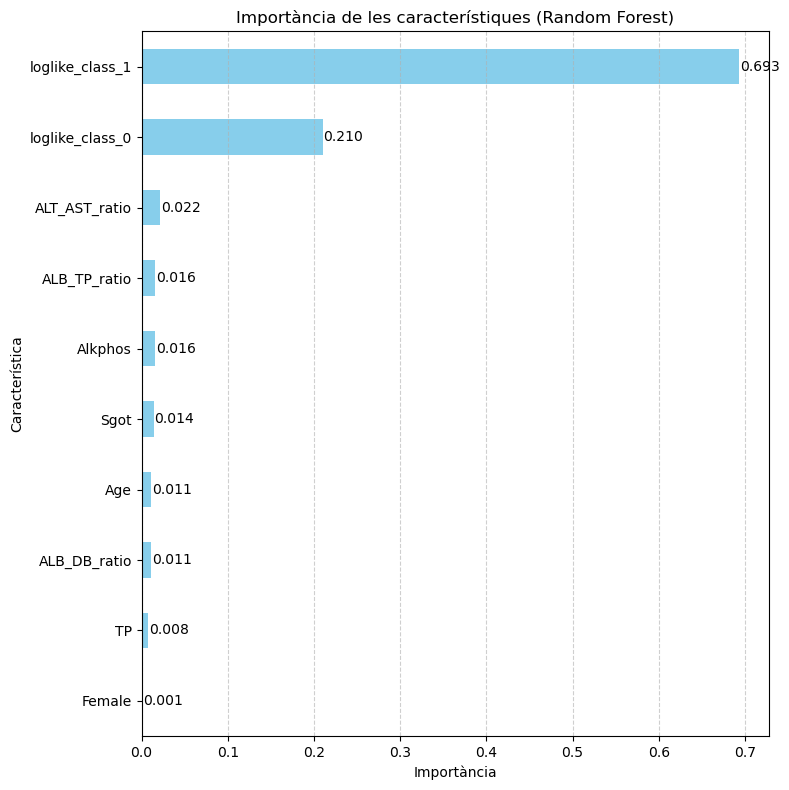

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Make sure you have X_train (original, amb noms de columnes)
# and X_train_scaled (numpy matrix after scaling)

# Create DataFrame with importances, using X_train column names
var_imp = pd.DataFrame({
    'importance': best_rf_model.feature_importances_
}, index=X_train_scaled.columns)

# Sorted plot
ax = var_imp.sort_values(by='importance').plot.barh(
    figsize=(8, 8),
    legend=False,
    color='skyblue'
)

# Visual details
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Values on bars
for i, v in enumerate(var_imp.sort_values(by='importance')['importance']):
    ax.text(v + 0.001, i, f"{v:.3f}", va='center')

plt.tight_layout()
plt.show()



In [29]:
rf_model.feature_importances_

from sklearn.svm import SVC
import joblib


array([7.14695963e-03, 2.79695186e-04, 2.68722896e-03, 6.28104024e-04,
       9.22978897e-03, 1.14231327e-02, 5.55613527e-03, 2.29490419e-03,
       6.22917802e-03, 9.95495327e-03, 1.75899328e-02, 7.52796268e-03,
       0.00000000e+00, 0.00000000e+00, 1.97241641e-01, 6.71618991e-01,
       3.53765623e-02, 1.52148291e-02])

## correlations

Let's look at the data before building models

## SVM

In [83]:
from sklearn.svm import SVC
import pandas as pd
import joblib
##cols_to_drop = ['Sgpt', 'TB_ALP_ratio', 'A/R','is_high_ALP', 'is_high_ALT_AST','DB', 'TB', 'B_ratio' , 'ALB']
## mahalanobis no, kde
# 1. Defineix el model
model_svc = SVC(probability=True, random_state=42)

# 2. Defineix la graella de paràmetres
param_grid_svc = {
    'C':            [0.01, 0.1, 1, 10, 100],
    'kernel':       ['rbf'],
    'gamma':        ['scale', 'auto', 0.01, 0.1, 1],
    'degree':       [2, 3, 4],  # només per poly
    'class_weight': [None, 'balanced'],
    'shrinking':    [True, False],
    'coef0':        [0.0, 0.1, 0.5, 1.0],  # només per poly i sigmoid
    'probability':  [True]
}

# 3. Crida a la funció perform_grid_search
best_svc_model, svc_metrics = perform_grid_search(X_train_scaled, y_train_filtered, model_svc, param_grid_svc)

# 4. Afegeix les mètriques al DataFrame results_summary
model_name = 'SVC'
results_summary.loc[model_name] = svc_metrics

# 5. Mostra resultats actualitzats
print("\n Updated summary of best models metrics:")
display(results_summary)

# 6. Genera submissió
submission_df = generate_submission(
    model_path="./models/best_model_svc.pkl",
    X_test=X_test_scaled,
    output_path="./submissions/submission_svc.csv",
    id_start=1,
    verbose=True
)

submission_df.head()


Fitting 25 folds for each of 1200 candidates, totalling 30000 fits

 Results saved to: gridsearch\gridsearch_results_svc_4558.csv

 Grid Search Results (sorted by F1 Macro):



,params,mean_test_accuracy,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro,mean_test_f1_class0,mean_test_recall_class0
1045,"{'C': 100, 'class_weight': None, 'coef0': 0.5, 'degree': 4, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True, 'shrinking': False}",0.863,0.814,0.862,0.791,0.909,0.958
1064,"{'C': 100, 'class_weight': None, 'coef0': 1.0, 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True, 'shrinking': True}",0.863,0.814,0.862,0.791,0.909,0.958
1035,"{'C': 100, 'class_weight': None, 'coef0': 0.5, 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True, 'shrinking': False}",0.863,0.814,0.862,0.791,0.909,0.958
1034,"{'C': 100, 'class_weight': None, 'coef0': 0.5, 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True, 'shrinking': True}",0.863,0.814,0.862,0.791,0.909,0.958
995,"{'C': 100, 'class_weight': None, 'coef0': 0.1, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True, 'shrinking': False}",0.863,0.814,0.862,0.791,0.909,0.958
...,...,...,...,...,...,...,...
156,"{'C': 0.01, 'class_weight': 'balanced', 'coef0': 0.1, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf', 'probability': True, 'shrinking': True}",0.541,0.338,0.271,0.500,0.500,0.600
155,"{'C': 0.01, 'class_weight': 'balanced', 'coef0': 0.1, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True, 'shrinking': False}",0.541,0.338,0.271,0.500,0.500,0.600
154,"{'C': 0.01, 'class_weight': 'balanced', 'coef0': 0.1, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True, 'shrinking': True}",0.541,0.338,0.271,0.500,0.500,0.600
153,"{'C': 0.01, 'class_weight': 'balanced', 'coef0': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'probability': True, 'shrinking': False}",0.541,0.338,0.271,0.500,0.500,0.600


 Model saved to: models\best_model_svc_4558.pkl


NameError: name 'results_summary' is not defined

## SVM 2

In [174]:
cols_to_drop = [
 'Gender', 'TB', 'DB', 'Sgpt', 'ALB', 'AG',
 'B_ratio', 'TB_ALP_ratio', 'is_high_ALP', 'is_high_ALT_AST','ALB_TP_ratio'
]

# 3. Preprocessament complet amb KDE log-likelihood, Mahalanobis i noves features
X_train_scaled, y_train_filtered, X_test_scaled, scaler_main, _, _= full_preprocess_pipeline(
    X_train_raw, y_train_raw, X_test_raw,
    cat=False,
    outliers=False,
    boxcox=False, 
    smote=False,
    new_features=True,
    log_likelihood="kde", 
    bandwidth_kde=None,
    mahalanobis=True,
    cols_to_drop = cols_to_drop

)


from sklearn.svm import SVC
import pandas as pd
import joblib

# 1. Defineix el model
model_svc = SVC(probability=True, random_state=42)

# 2. Defineix la graella de paràmetres
param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf'],
    'class_weight': ['balanced'],
    'shrinking': [False]
}


# 3. Crida a la funció perform_grid_search
best_svc_model, svc_metrics = perform_grid_search(X_train_scaled, y_train_filtered, model_svc, param_grid_svc)

# 4. Afegeix les mètriques al DataFrame results_summary
model_name = 'SVC'
results_summary.loc[model_name] = svc_metrics

# 5. Mostra resultats actualitzats
print("\n Updated summary of best models metrics:")
display(results_summary)

# 6. Genera submissió
submission_df = generate_submission(
    model_path="./models/best_model_svc.pkl",
    X_test=X_test_scaled,
    output_path="./submissions/submission_svc.csv",
    id_start=1,
    verbose=True
)

submission_df.head()


Fitting 25 folds for each of 16 candidates, totalling 400 fits

 Results saved to: gridsearch\gridsearch_results_svc_5779.csv

 Grid Search Results (sorted by F1 Macro):



,params,mean_test_accuracy,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro,mean_test_f1_class0,mean_test_recall_class0
13,"{'C': 100, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf', 'shrinking': False}",0.838,0.813,0.802,0.836,0.881,0.840
9,"{'C': 10, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf', 'shrinking': False}",0.791,0.765,0.757,0.795,0.843,0.785
12,"{'C': 100, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': False}",0.794,0.755,0.751,0.764,0.853,0.835
8,"{'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': False}",0.781,0.747,0.742,0.766,0.839,0.801
10,"{'C': 10, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf', 'shrinking': False}",0.778,0.744,0.738,0.762,0.836,0.799
14,"{'C': 100, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf', 'shrinking': False}",0.784,0.742,0.739,0.751,0.845,0.828
4,"{'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': False}",0.736,0.709,0.707,0.742,0.796,0.728
6,"{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf', 'shrinking': False}",0.737,0.708,0.706,0.740,0.798,0.732
5,"{'C': 1, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf', 'shrinking': False}",0.683,0.662,0.673,0.708,0.743,0.649
0,"{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': False}",0.648,0.635,0.664,0.699,0.700,0.580


 Model saved to: models\best_model_svc_5779.pkl


NameError: name 'results_summary' is not defined


 Top 10 features per importància (Permutation Importance):


,feature,importance_mean,importance_std
8,loglike_class_0,0.297,0.015
9,loglike_class_1,0.080,0.019
6,ALT_AST_ratio,0.028,0.009
10,dist_mah_class0,0.028,0.014
7,ALB_DB_ratio,0.026,0.009
3,Sgot,0.026,0.006
1,Female,0.025,0.007
4,TP,0.021,0.005
0,Age,0.020,0.006
11,dist_mah_class1,0.017,0.010


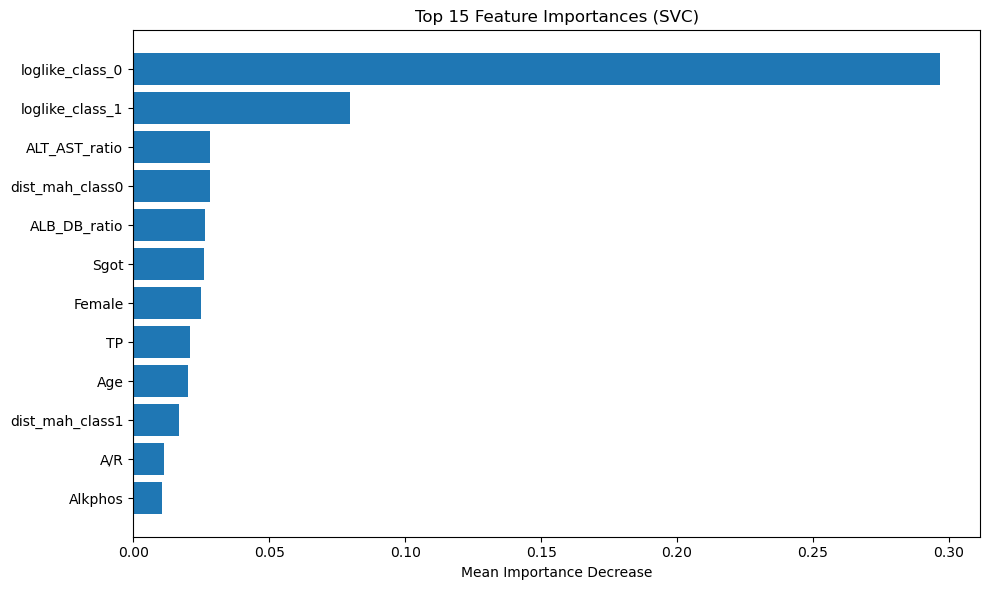

In [176]:

# Ara tenim els noms correctes
feature_names = X_train_scaled.columns

#  Importance de permutació
result = permutation_importance(
    best_svc_model, 
    X_train_scaled, 
    y_train_filtered, 
    n_repeats=10, 
    random_state=42, 
    n_jobs=-1
)

#  DataFrame amb importància
importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

#  Top 10
print("\n Top 10 features per importància (Permutation Importance):")
display(importances_df.head(10))

#  Gràfic
plt.figure(figsize=(10, 6))
plt.barh(importances_df['feature'].head(15)[::-1], importances_df['importance_mean'].head(15)[::-1])
plt.xlabel('Mean Importance Decrease')
plt.title('Top 15 Feature Importances (SVC)')
plt.tight_layout()
plt.show()


idea 1: el preprocessat no elimina la variable quan li fa el log!

idea 2: eliminar altes correlacions abans dentrenar

idea 3: eliminar variables originals i reentrenar 

idea 4: reentrenar i eliminar poqeus importances



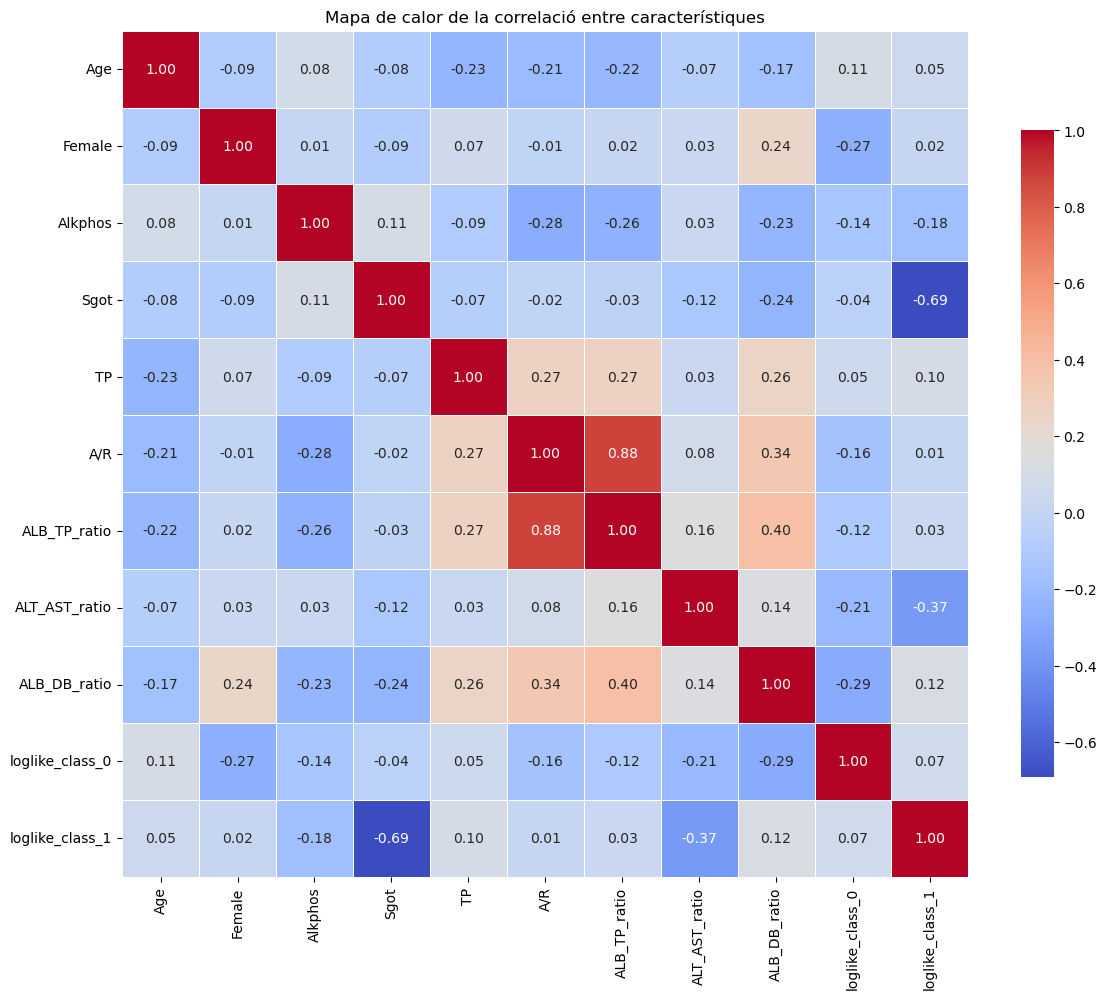


 Correlacions ordenades (valor absolut):
          Feature 1        Feature 2  Correlation  AbsCorrelation
40              A/R     ALB_TP_ratio        0.876           0.876
33             Sgot  loglike_class_1       -0.692           0.692
46     ALB_TP_ratio     ALB_DB_ratio        0.397           0.397
51    ALT_AST_ratio  loglike_class_1       -0.372           0.372
42              A/R     ALB_DB_ratio        0.342           0.342
52     ALB_DB_ratio  loglike_class_0       -0.291           0.291
21          Alkphos              A/R       -0.279           0.279
34               TP              A/R        0.271           0.271
35               TP     ALB_TP_ratio        0.268           0.268
17           Female  loglike_class_0       -0.266           0.266
37               TP     ALB_DB_ratio        0.259           0.259
22          Alkphos     ALB_TP_ratio       -0.258           0.258
16           Female     ALB_DB_ratio        0.242           0.242
31             Sgot     ALB_DB_rat

In [162]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  #  Faltava aquesta importació

# 1. Convertim X_train_scaled en DataFrame amb noms
X_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_scaled.columns)

# 2. Calculem la matriu de correlació
corr_matrix = X_scaled_df.corr()

# 3. Fem el heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={"shrink": 0.75}, linewidths=0.5)

plt.title("Mapa de calor de la correlació entre característiques")
plt.tight_layout()
plt.show()

# 4. Creem un DataFrame amb les correlacions úniques (sense duplicats ni diagonal)
corr_pairs = corr_matrix.where(~np.tril(np.ones(corr_matrix.shape)).astype(bool))
corr_pairs = corr_pairs.stack().reset_index()
corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

# 5. Afegim la correlació absoluta i ordenem
corr_pairs['AbsCorrelation'] = corr_pairs['Correlation'].abs()
corr_pairs_sorted = corr_pairs.sort_values(by='AbsCorrelation', ascending=False)

# 6. Imprimim les correlacions ordenades
print("\n Correlacions ordenades (valor absolut):")
print(corr_pairs_sorted)  #  Aquesta línia estava mal tancada


### SVM 3

In [200]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import pandas as pd

ks = [5, 6, 7, 10, 12]
results_pca = []

for k in ks:
    print(f"\n Prova PCA amb {k} components")
    
    # Aplica PCA
    pca = PCA(n_components=k, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # Define the model i la graella
    model_svc = SVC(probability=True, random_state=42)
    param_grid_svc = {
        'C': [10, 100],
        'gamma': ['scale', 0.01],
        'kernel': ['rbf'],
        'class_weight': ['balanced'],
        'shrinking': [False]
    }
    
    # Entrena i busca millors paràmetres
    best_model, svc_metrics = perform_grid_search(X_train_pca, y_train_filtered, model_svc, param_grid_svc)
    
    print(f"Metrics per k={k}:")
    print(svc_metrics)
    
    # Guarda resultats amb les claus reals que tens:
    results_pca.append({
        'pca_components': k,
        'f1_macro': svc_metrics.get('F1 Macro'),
        'accuracy': svc_metrics.get('Accuracy'),
        'precision_macro': svc_metrics.get('Precision Macro'),
        'recall_macro': svc_metrics.get('Recall Macro'),
        'best_params': svc_metrics  # Pots guardar tot l'objecte sencer si vols
    })

# Converteix a DataFrame i ordena per F1 Macro descendent
results_pca_df = pd.DataFrame(results_pca).sort_values(by='f1_macro', ascending=False)

print("\n Resultats resum per diferents k de PCA:")
display(results_pca_df)



 Prova PCA amb 5 components
Fitting 25 folds for each of 4 candidates, totalling 100 fits

 Results saved to: gridsearch\gridsearch_results_svc_1865.csv

 Grid Search Results (sorted by F1 Macro):



,params,mean_test_accuracy,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro,mean_test_f1_class0,mean_test_recall_class0
0,"{'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': False}",0.694,0.677,0.688,0.730,0.750,0.646
2,"{'C': 100, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': False}",0.688,0.666,0.672,0.709,0.751,0.661
3,"{'C': 100, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf', 'shrinking': False}",0.678,0.665,0.689,0.730,0.729,0.609
1,"{'C': 10, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf', 'shrinking': False}",0.656,0.648,0.685,0.723,0.701,0.567


 Model saved to: models\best_model_svc_1865.pkl
Metrics per k=5:
{'Recall class 0': 0.6464586160108549, 'F1 class 0': 0.7502621171616803, 'Accuracy': 0.6938616175783077, 'F1 Macro': 0.6766233004305061, 'Precision Macro': 0.6881077634530642, 'Recall Macro': 0.7295825843587038}

 Prova PCA amb 6 components
Fitting 25 folds for each of 4 candidates, totalling 100 fits

 Results saved to: gridsearch\gridsearch_results_svc_5995.csv

 Grid Search Results (sorted by F1 Macro):



,params,mean_test_accuracy,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro,mean_test_f1_class0,mean_test_recall_class0
3,"{'C': 100, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf', 'shrinking': False}",0.758,0.736,0.734,0.777,0.811,0.733
2,"{'C': 100, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': False}",0.759,0.731,0.725,0.761,0.817,0.756
0,"{'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': False}",0.720,0.696,0.697,0.736,0.780,0.698
1,"{'C': 10, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf', 'shrinking': False}",0.698,0.684,0.705,0.747,0.747,0.632


 Model saved to: models\best_model_svc_5995.pkl
Metrics per k=6:
{'Recall class 0': 0.73280868385346, 'F1 class 0': 0.8110938799032016, 'Accuracy': 0.7581252921926135, 'F1 Macro': 0.7361058766822514, 'Precision Macro': 0.734065494710276, 'Recall Macro': 0.7771450826674707}

 Prova PCA amb 7 components
Fitting 25 folds for each of 4 candidates, totalling 100 fits

 Results saved to: gridsearch\gridsearch_results_svc_5109.csv

 Grid Search Results (sorted by F1 Macro):



,params,mean_test_accuracy,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro,mean_test_f1_class0,mean_test_recall_class0
3,"{'C': 100, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf', 'shrinking': False}",0.772,0.748,0.743,0.786,0.824,0.752
2,"{'C': 100, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': False}",0.758,0.729,0.722,0.758,0.817,0.759
0,"{'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': False}",0.745,0.721,0.717,0.758,0.803,0.728
1,"{'C': 10, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf', 'shrinking': False}",0.735,0.720,0.731,0.779,0.783,0.677


 Model saved to: models\best_model_svc_5109.pkl
Metrics per k=7:
{'Recall class 0': 0.7521845318860244, 'F1 class 0': 0.8241107961745645, 'Accuracy': 0.7715007012622722, 'F1 Macro': 0.7482719040678205, 'Precision Macro': 0.742638389183511, 'Recall Macro': 0.785978305829052}

 Prova PCA amb 10 components
Fitting 25 folds for each of 4 candidates, totalling 100 fits

 Results saved to: gridsearch\gridsearch_results_svc_7670.csv

 Grid Search Results (sorted by F1 Macro):



,params,mean_test_accuracy,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro,mean_test_f1_class0,mean_test_recall_class0
3,"{'C': 100, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf', 'shrinking': False}",0.798,0.776,0.769,0.814,0.846,0.777
2,"{'C': 100, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': False}",0.803,0.771,0.763,0.787,0.857,0.825
0,"{'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': False}",0.767,0.743,0.738,0.780,0.821,0.750
1,"{'C': 10, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf', 'shrinking': False}",0.737,0.721,0.732,0.780,0.785,0.680


 Model saved to: models\best_model_svc_7670.pkl
Metrics per k=10:
{'Recall class 0': 0.7770058796924469, 'F1 class 0': 0.8455766764963484, 'Accuracy': 0.7983169705469847, 'F1 Macro': 0.7764996719156833, 'Precision Macro': 0.7688762195794737, 'Recall Macro': 0.8142579256012092}

 Prova PCA amb 12 components
Fitting 25 folds for each of 4 candidates, totalling 100 fits

 Results saved to: gridsearch\gridsearch_results_svc_8486.csv

 Grid Search Results (sorted by F1 Macro):



,params,mean_test_accuracy,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro,mean_test_f1_class0,mean_test_recall_class0
3,"{'C': 100, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf', 'shrinking': False}",0.820,0.798,0.788,0.832,0.864,0.804
2,"{'C': 100, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': False}",0.813,0.781,0.773,0.798,0.864,0.833
0,"{'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': False}",0.773,0.748,0.742,0.784,0.827,0.759
1,"{'C': 10, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf', 'shrinking': False}",0.735,0.721,0.734,0.784,0.782,0.670


 Model saved to: models\best_model_svc_8486.pkl
Metrics per k=12:
{'Recall class 0': 0.8041700587969244, 'F1 class 0': 0.8638609393669638, 'Accuracy': 0.8199438990182328, 'F1 Macro': 0.7980921028668639, 'Precision Macro': 0.7883230785342269, 'Recall Macro': 0.8317146590280919}

 Resultats resum per diferents k de PCA:


,pca_components,f1_macro,accuracy,precision_macro,recall_macro,best_params
4,12,0.798,0.820,0.788,0.832,"{'Recall class 0': 0.8041700587969244, 'F1 class 0': 0.8638609393669638, 'Accuracy': 0.8199438990182328, 'F1 Macro': 0.7980921028668639, 'Precision Macro': 0.7883230785342269, 'Recall Macro': 0.8317146590280919}"
3,10,0.776,0.798,0.769,0.814,"{'Recall class 0': 0.7770058796924469, 'F1 class 0': 0.8455766764963484, 'Accuracy': 0.7983169705469847, 'F1 Macro': 0.7764996719156833, 'Precision Macro': 0.7688762195794737, 'Recall Macro': 0.8142579256012092}"
2,7,0.748,0.772,0.743,0.786,"{'Recall class 0': 0.7521845318860244, 'F1 class 0': 0.8241107961745645, 'Accuracy': 0.7715007012622722, 'F1 Macro': 0.7482719040678205, 'Precision Macro': 0.742638389183511, 'Recall Macro': 0.785978305829052}"
1,6,0.736,0.758,0.734,0.777,"{'Recall class 0': 0.73280868385346, 'F1 class 0': 0.8110938799032016, 'Accuracy': 0.7581252921926135, 'F1 Macro': 0.7361058766822514, 'Precision Macro': 0.734065494710276, 'Recall Macro': 0.7771450826674707}"
0,5,0.677,0.694,0.688,0.730,"{'Recall class 0': 0.6464586160108549, 'F1 class 0': 0.7502621171616803, 'Accuracy': 0.6938616175783077, 'F1 Macro': 0.6766233004305061, 'Precision Macro': 0.6881077634530642, 'Recall Macro': 0.7295825843587038}"


In [198]:
best_model, svc_metrics = perform_grid_search(X_train_pca, y_train_filtered, model_svc, param_grid_svc)
print(svc_metrics)  # <-- Mira aquí quines claus tens!


Fitting 25 folds for each of 4 candidates, totalling 100 fits

 Results saved to: gridsearch\gridsearch_results_svc_1948.csv

 Grid Search Results (sorted by F1 Macro):



,params,mean_test_accuracy,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro,mean_test_f1_class0,mean_test_recall_class0
3,"{'C': 100, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf', 'shrinking': False}",0.820,0.798,0.788,0.832,0.864,0.804
2,"{'C': 100, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': False}",0.813,0.781,0.773,0.798,0.864,0.833
0,"{'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': False}",0.773,0.748,0.742,0.784,0.827,0.759
1,"{'C': 10, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf', 'shrinking': False}",0.735,0.721,0.734,0.784,0.782,0.670


 Model saved to: models\best_model_svc_1948.pkl
{'Recall class 0': 0.8041700587969244, 'F1 class 0': 0.8638609393669638, 'Accuracy': 0.8199438990182328, 'F1 Macro': 0.7980921028668639, 'Precision Macro': 0.7883230785342269, 'Recall Macro': 0.8317146590280919}


## SUbmission

# 5779

In [152]:
import pandas as pd
import joblib

submission_df = generate_submission(
    model_path="./models/best_model_svc_7889.pkl",
    X_test=X_test_scaled,
    output_path="./submissions/submission_svc_7889.csv",
    id_start=1,
    verbose=True
)

submission_df.head()


 Loading model from ./models/best_model_svc_7889.pkl...
 Submission saved to: submissions\submission_svc_7889.csv
 Label Distribution:
Label
1    72
0    44
Name: count, dtype: int64


,ID,Label
0,1,0
1,2,1
2,3,1
3,4,0
4,5,1


In [158]:
import joblib

model = joblib.load('./models/best_model_svc_4558.pkl')

# If it's a pipeli  ne, you can check the feature names in the preprocessing step
# For example, if first step is a column selector or transformer

# Or if the model has a `feature_names_in_` attribute (some sklearn models do)
if hasattr(model, 'feature_names_in_'):
    print(model.feature_names_in_)
else:
    print("Model doesn't have feature names stored.")


['Age' 'Female' 'Alkphos' 'Sgot' 'TP' 'ALB_TP_ratio' 'ALT_AST_ratio'
 'ALB_DB_ratio' 'loglike_class_0' 'loglike_class_1']
